In [115]:
# !pip install prophet

In [192]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.impute import SimpleImputer
from scipy.stats import shapiro, boxcox, yeojohnson
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import kruskal
np.random.seed(22)
random.seed(22)

In [117]:
df = pd.read_parquet('../Data/Interim/merged.parquet')

In [118]:
# Convert year and month to integer types, then to string, and combine
df['date'] = df['year'].astype(str) + df['month'].astype(str).str.zfill(2)
df.date = df.date.astype(int)
# Sort the dataframe by the new date variable
df = df.sort_values(by='date')


In [119]:
df.head()

,year,month,region,district,site_code,product_code,stock_initial,stock_received,stock_distributed,stock_adjustment,stock_end,average_monthly_consumption,stock_ordered,site_type,date
31887,2016,1,ABIDJAN 2,KOUMASSI-PORT BOUET-VRIDI,C1024,AS27137,46,0,2,0,44,1,0.0,Health Center,201601
35066,2016,1,ABIDJAN 1-GRANDS PONTS,YOPOUGON-EST,C1073,AS27000,0,0,0,0,0,0,150.0,Health Center,201601
35065,2016,1,ABIDJAN 1-GRANDS PONTS,YOPOUGON-EST,C1073,AS27132,0,0,0,0,0,0,5.0,Health Center,201601
35064,2016,1,ABIDJAN 1-GRANDS PONTS,YOPOUGON-EST,C1073,AS27137,0,0,0,0,0,0,10.0,Health Center,201601
35063,2016,1,ABIDJAN 1-GRANDS PONTS,YOPOUGON-EST,C1073,AS27138,0,0,0,0,0,0,10.0,Health Center,201601


In [120]:
df.describe()

,year,month,stock_initial,stock_received,stock_distributed,stock_adjustment,stock_end,average_monthly_consumption,stock_ordered,date
count,35753.000000,35753.000000,35753.000000,35753.000000,35753.000000,35753.000000,35753.000000,35753.000000,34990.000000,35753.000000
mean,2017.433782,6.169412,63.245518,14.846055,14.764327,0.961150,64.288395,14.606439,26.658102,201749.547590
std,1.019933,3.429079,168.661538,70.631782,39.848242,37.883099,170.848479,32.521384,107.166082,101.100137
min,2016.000000,1.000000,0.000000,0.000000,0.000000,-1440.000000,0.000000,0.000000,0.000000,201601.000000
25%,2017.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,201702.000000
50%,2017.000000,6.000000,12.000000,0.000000,1.000000,0.000000,13.000000,3.000000,0.000000,201712.000000
75%,2018.000000,9.000000,69.000000,0.000000,13.000000,0.000000,70.000000,16.000000,20.000000,201810.000000
max,2019.000000,12.000000,4320.000000,3534.000000,1728.000000,3003.000000,4320.000000,864.000000,10240.000000,201906.000000


In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35753 entries, 31887 to 5383
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   year                         35753 non-null  int64  
 1   month                        35753 non-null  int64  
 2   region                       35753 non-null  object 
 3   district                     35753 non-null  object 
 4   site_code                    35753 non-null  object 
 5   product_code                 35753 non-null  object 
 6   stock_initial                35753 non-null  int64  
 7   stock_received               35753 non-null  int64  
 8   stock_distributed            35753 non-null  int64  
 9   stock_adjustment             35753 non-null  int64  
 10  stock_end                    35753 non-null  int64  
 11  average_monthly_consumption  35753 non-null  int64  
 12  stock_ordered                34990 non-null  float64
 13  site_type    

In [122]:
# Splitting the data to train and test sets
# Using date > 2021811 as will ensure about 80-20 percent train-test split 
df_train = df[df['date'] < 201811]
df_test = df[df['date'] >= 201811]

In [123]:
# Function to print out the number of missing values and the percentages for columns with at least a missing value.
def missing_percentage(df):
    # Calculate the total missing values and the percentage missing for each column
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False) * 100

    # Create a new dataframe from the total and percentage
    missing_data = pd.concat([total, percent], axis=1, keys=['Total Missing', 'Missing %'])

    # Return the dataframe sorted by percentage of missing values in descending order
    return missing_data[missing_data['Total Missing'] > 0]


In [124]:
missing_percentage(df_train)

,Total Missing,Missing %
stock_ordered,703,2.545902


In [125]:
missing_percentage(df_test)

,Total Missing,Missing %
stock_ordered,60,0.737101


In [126]:
def missing_value_percentage(df, column_name, groupby_column):
    """
    This function calculates the missing value percentage in a specified column grouped by another column.

    :param df: pandas DataFrame
    :param column_name: Name of the column to check for missing values
    :param groupby_column: Name of the column to group by
    :return: DataFrame with missing value percentage for each group
    """
    total_count = df.groupby(groupby_column).size()
    missing_count = df[df[column_name].isnull()].groupby(groupby_column).size()

    missing_percentage = (missing_count / total_count) * 100
    return missing_percentage.reset_index(name=f'{column_name} Missing Percentage')


missing_df = missing_value_percentage(df_train, 'stock_ordered', 'region')
print(missing_df)


                     region  stock_ordered Missing Percentage
0    ABIDJAN 1-GRANDS PONTS                          0.976620
1                 ABIDJAN 2                          6.332401
2          AGNEBY-TIASSA-ME                          1.979638
3                    BELIER                          0.076161
4         BOUNKANI-GONTOUGO                          0.666667
5            CAVALLY-GUEMON                          0.726392
6                     GBEKE                          0.531915
7     GBOKLE-NAWA-SAN PEDRO                          0.337838
8                       GOH                          0.118343
9                    HAMBOL                          0.826446
10           HAUT-SASSANDRA                          0.756144
11         INDENIE-DJUABLIN                         16.743119
12  KABADOUGOU-BAFING-FOLON                          0.829384
13              LOH-DJIBOUA                          0.563698
14                 MARAHOUE                               NaN
15      

In [127]:
def impute_missing_values(df, strategy='median'):
    """
    Impute missing values in a DataFrame.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - strategy (str): The imputation strategy. Default is 'mean'. 
                      Other options include 'median', 'most_frequent', and 'constant'.

    Returns:
    - df_imputed (pd.DataFrame): DataFrame with imputed values.
    """
    # Copy the dataframe to avoid modifying the original
    df_imputed = df.copy()

    # Initialize the imputer
    imputer = SimpleImputer(strategy=strategy)

    # For each column, apply imputation and add a flag column if there are missing values
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            # Add a flag column
            df_imputed[col + '_imputed_flag'] = df[col].isnull().astype(int)
            # Impute the column
            df_imputed[col] = imputer.fit_transform(df[[col]])

    return df_imputed

df_train = impute_missing_values(df_train)
df_test = impute_missing_values(df_test)

In [128]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8140 entries, 7336 to 5383
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   year                         8140 non-null   int64  
 1   month                        8140 non-null   int64  
 2   region                       8140 non-null   object 
 3   district                     8140 non-null   object 
 4   site_code                    8140 non-null   object 
 5   product_code                 8140 non-null   object 
 6   stock_initial                8140 non-null   int64  
 7   stock_received               8140 non-null   int64  
 8   stock_distributed            8140 non-null   int64  
 9   stock_adjustment             8140 non-null   int64  
 10  stock_end                    8140 non-null   int64  
 11  average_monthly_consumption  8140 non-null   int64  
 12  stock_ordered                8140 non-null   float64
 13  site_type      

In [129]:
def remove_duplicate_rows(df):
    # Check number of duplicate rows
    num_duplicates = df.duplicated().sum()

    # Remove duplicate rows
    df_no_duplicates = df.drop_duplicates()

    return df_no_duplicates, num_duplicates

df_train, num_duplicates_tr = remove_duplicate_rows(df_train)
df_test, num_duplicates_tst = remove_duplicate_rows(df_test)
print("Number of duplicated rows removed in the train set:", num_duplicates_tr)
print("Number of duplicated rows removed in the test set:", num_duplicates_tst)

Number of duplicated rows removed in the train set: 0
Number of duplicated rows removed in the test set: 0


In [130]:
# # Function that identifiers and replaces outliers
# def handle_extreme_values(df, exclude_cols=[], method="cap"):
#     df_copy = df.copy()
# 
#     # Filter the numerical columns excluding the specified columns
#     numerical_cols = df_copy.select_dtypes(include=[np.number]).columns.difference(exclude_cols)
# 
#     for column in numerical_cols:
#         Q1 = df_copy[column].quantile(0.25)
#         Q3 = df_copy[column].quantile(0.75)
#         IQR = Q3 - Q1
# 
#         lower_bound = Q1 - 1.5 * IQR
#         upper_bound = Q3 + 1.5 * IQR
# 
#         if method == "cap":
#             df_copy[column] = np.where(df_copy[column] < lower_bound, lower_bound, df_copy[column])
#             df_copy[column] = np.where(df_copy[column] > upper_bound, upper_bound, df_copy[column])
#         elif method == "remove":
#             df_copy = df_copy[(df_copy[column] >= lower_bound) & (df_copy[column] <= upper_bound)]
#         elif method == "mean_mode_median":
#             replacement = np.mean([df_copy[column].mean(), df_copy[column].mode()[0], df_copy[column].median()])
#             df_copy[column] = np.where((df_copy[column] < lower_bound) | (df_copy[column] > upper_bound), replacement, df_copy[column])
#         elif method == "mean":
#             replacement = df_copy[column].mean()
#             df_copy[column] = np.where((df_copy[column] < lower_bound) | (df_copy[column] > upper_bound), replacement, df_copy[column])
#         elif method == "mode":
#             replacement = df_copy[column].mode()[0]
#             df_copy[column] = np.where((df_copy[column] < lower_bound) | (df_copy[column] > upper_bound), replacement, df_copy[column])
#         elif method == "median":
#             replacement = df_copy[column].median()
#             df_copy[column] = np.where((df_copy[column] < lower_bound) | (df_copy[column] > upper_bound), replacement, df_copy[column])
# 
#     return df_copy
# 
# df_train = handle_extreme_values(df_train, exclude_cols=['stock_ordered_imputed'], method='median')
# df_test = handle_extreme_values(df_test, exclude_cols=['stock_ordered_imputed'], method='median')

In [131]:
df_train.stock_adjustment.nunique()

350

In [132]:
# df_clean_train = df_train.drop(['stock_received', 'stock_adjustment', 'stock_ordered_imputed'], axis=1)
# df_clean_test = df_test.drop(['stock_received', 'stock_adjustment', 'stock_ordered_imputed'], axis=1)
df_clean_train = df_train.copy()
df_clean_test = df_test.copy()

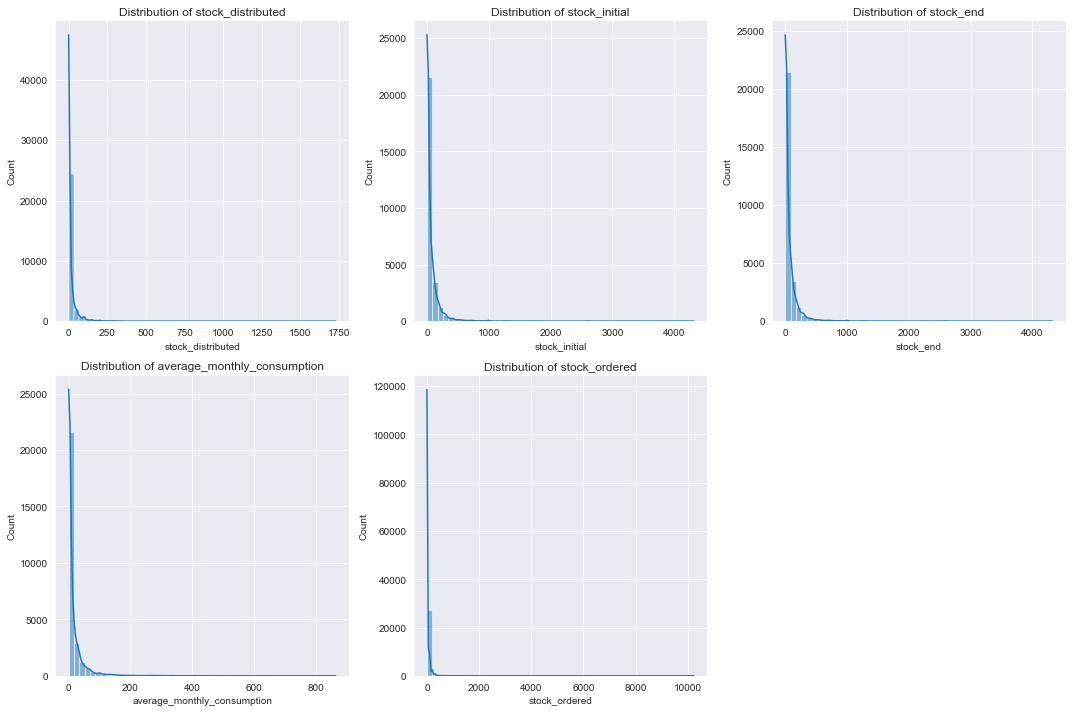

In [133]:
columns_to_visualize = [
    'stock_distributed',
    'stock_initial',
    'stock_end',
    'average_monthly_consumption',
    'stock_ordered'
]

# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

for i, col in enumerate(columns_to_visualize, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df_clean_train[col], bins=50, kde=True)
    plt.title(f'Distribution of {col}')
    plt.tight_layout()

plt.show()

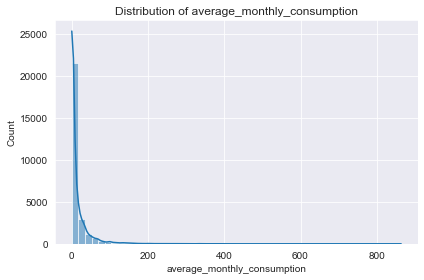

In [134]:
sns.histplot(df_clean_train['average_monthly_consumption'], bins=50, kde=True)
plt.title(f'Distribution of average_monthly_consumption')
plt.tight_layout()

C:\Users\andil\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\andil\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


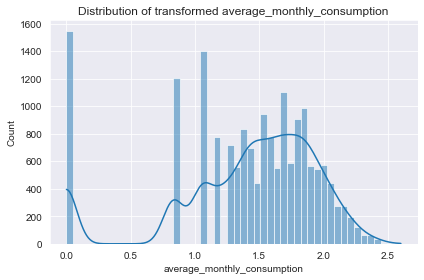

In [135]:
transformed = np.log(df_clean_train['average_monthly_consumption'])
transformed = np.sqrt(transformed)
sns.histplot(transformed, bins=50, kde=True)
plt.title(f'Distribution of transformed average_monthly_consumption')
plt.tight_layout()

In [136]:
def correct_skewness(df, column, alpha=0.05, max_iterations=5):
    """
    Checks for skewness in the column data, applies a series of transformations until the data is 
    approximately normal, and returns the transformed data along with distribution plots.
    
    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - column (str): The column to check for skewness.
    - alpha (float): Significance level for the Shapiro-Wilk test. Default is 0.05.
    - max_iterations (int): Maximum number of transformations to attempt. Default is 5.

    Returns:
    - transformed_data (pd.Series): Transformed data.
    - Plot: Distribution plots of original and transformed data.
    - log (list): A log of transformations and decisions made.
    """
    log = []  # To document every step of the decision

    # Original data
    data = df[column]

    # Create a function to test for normality
    def is_normal(data):
        stat, p = shapiro(data)
        return p >= alpha

    # Define a series of transformations
    transformations = [
        ('Log Transformation', lambda x: np.log(x)),
        ('Square Root Transformation', lambda x: np.sqrt(x)),
        ('Box-Cox Transformation', lambda x: boxcox(x)[0]),
        ('Yeo-Johnson Transformation', lambda x: yeojohnson(x)[0]),
        ('Inverse Transformation', lambda x: 1 / (x + 1e-5)),  # Adding a small value to avoid division by zero
        ('Exponential Transformation', lambda x: np.exp(x))
    ]

    transformed_data = data.copy()
    iteration = 0
    while not is_normal(transformed_data) and iteration < max_iterations:
        transformation_name, transformation_func = transformations[iteration]
        try:
            transformed_data = transformation_func(data)
            log.append(f"Applied {transformation_name}")
        except Exception as e:
            log.append(f"Failed to apply {transformation_name} due to: {str(e)}")
        iteration += 1

    # If still not normal after max_iterations, revert to original data
    if not is_normal(transformed_data):
        transformed_data = data.copy()
        log.append("Reverted to original data after reaching max iterations")

    # Plotting the distributions
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    sns.histplot(data, ax=ax1, kde=True, color='blue')
    ax1.set_title('Original Distribution')
    ax1.set_xlabel(column)
    ax1.set_ylabel('Frequency')

    sns.histplot(transformed_data, ax=ax2, kde=True, color='green')
    ax2.set_title('Transformed Distribution')
    ax2.set_xlabel(column)
    ax2.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    return transformed_data, log


C:\Users\andil\anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\andil\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


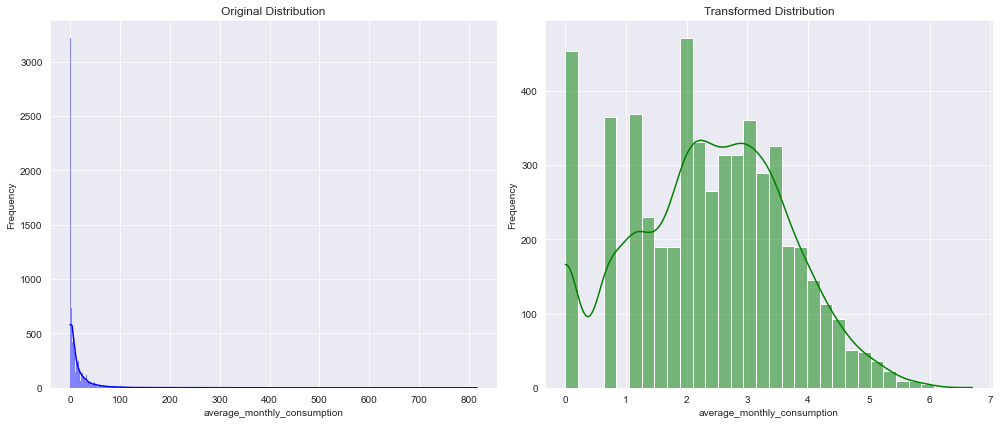

['Applied Log Transformation']


In [137]:
# [correct_skewness(df, col) for col in columns_to_visualize]
_, log = correct_skewness(df_clean_test, 'average_monthly_consumption')
print(log)

In [138]:
# Feature Engineering

# Temporal Features
df_clean_train['quarter'] = df_clean_train['month'].apply(lambda x: (x - 1) // 3 + 1)
df_clean_test['quarter'] = df['month'].apply(lambda x: (x - 1) // 3 + 1)


# Add some on another iteration
df_clean_train['stock_to_demand_ratio'] = df_clean_train.stock_end / df_clean_train.average_monthly_consumption
df_clean_test['stock_to_demand_ratio'] = df_clean_test.stock_end / df_clean_test.average_monthly_consumption

In [139]:
df_clean_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27613 entries, 31887 to 8921
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   year                         27613 non-null  int64  
 1   month                        27613 non-null  int64  
 2   region                       27613 non-null  object 
 3   district                     27613 non-null  object 
 4   site_code                    27613 non-null  object 
 5   product_code                 27613 non-null  object 
 6   stock_initial                27613 non-null  int64  
 7   stock_received               27613 non-null  int64  
 8   stock_distributed            27613 non-null  int64  
 9   stock_adjustment             27613 non-null  int64  
 10  stock_end                    27613 non-null  int64  
 11  average_monthly_consumption  27613 non-null  int64  
 12  stock_ordered                27613 non-null  float64
 13  site_type    

In [140]:

# Function to create new features
def create_features(df):
    # Rolling averages for stock_distributed
    df['rolling_avg_3m_stock_dist'] = df.groupby(['site_code', 'product_code'])['stock_distributed'].transform(lambda x: x.rolling(3, min_periods=1).mean())
    df['rolling_avg_6m_stock_dist'] = df.groupby(['site_code', 'product_code'])['stock_distributed'].transform(lambda x: x.rolling(6, min_periods=1).mean())

    # Seasonal indicators
    df['high_demand_season'] = df['month'].apply(lambda x: 1 if x in [6, 7, 8] else 0)  # Example: High demand in June, July, August
    df['low_demand_season'] = df['month'].apply(lambda x: 1 if x in [1, 2, 3] else 0)   # Example: Low demand in January, February, March

    # Rate of change in stock distributed
    df['rate_change_stock_dist'] = df.groupby(['site_code', 'product_code'])['stock_distributed'].pct_change().fillna(0)

    # Product-Site Interaction (as a concatenated string for simplicity; consider more sophisticated encoding for modeling)
    df['product_site_interaction'] = df['product_code'] + "_" + df['site_code']

    # Stock Sufficiency Indicator
    df['stock_sufficiency'] = np.where(df['stock_end'] >= df['average_monthly_consumption'], 1, 0)

    # Cumulative Stock Received and Distributed
    df['cumulative_stock_received'] = df.groupby(['site_code', 'product_code'])['stock_received'].cumsum()
    df['cumulative_stock_distributed'] = df.groupby(['site_code', 'product_code'])['stock_distributed'].cumsum()

    # Demand Variability
    df['std_dev_6m_stock_dist'] = df.groupby(['site_code', 'product_code'])['stock_distributed'].transform(lambda x: x.rolling(6, min_periods=1).std())

    # Lag Features
    df['lag_1_stock_dist'] = df.groupby(['site_code', 'product_code'])['stock_distributed'].shift(1).fillna(0)
    df['lag_2_stock_dist'] = df.groupby(['site_code', 'product_code'])['stock_distributed'].shift(2).fillna(0)

    # Stock Movement Features
    df['net_stock_change'] = df['stock_received'] - df['stock_distributed']
    
    #  Consumption Rate
    df['consumption_rate'] = df['stock_distributed'] / (df['stock_initial'] + 1)  # Adding 1 to avoid division by zero

    return df

# Apply the function to create features
df_clean_train = create_features(df_clean_train)
df_clean_test = create_features(df_clean_test)


In [141]:
df_clean_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27613 entries, 31887 to 8921
Data columns (total 32 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   year                          27613 non-null  int64  
 1   month                         27613 non-null  int64  
 2   region                        27613 non-null  object 
 3   district                      27613 non-null  object 
 4   site_code                     27613 non-null  object 
 5   product_code                  27613 non-null  object 
 6   stock_initial                 27613 non-null  int64  
 7   stock_received                27613 non-null  int64  
 8   stock_distributed             27613 non-null  int64  
 9   stock_adjustment              27613 non-null  int64  
 10  stock_end                     27613 non-null  int64  
 11  average_monthly_consumption   27613 non-null  int64  
 12  stock_ordered                 27613 non-null  float64
 13

In [142]:
# pd.concat([df_clean_train, df_clean_test]).to_csv('data.csv')
df_clean_train.columns

Index(['year', 'month', 'region', 'district', 'site_code', 'product_code',
       'stock_initial', 'stock_received', 'stock_distributed',
       'stock_adjustment', 'stock_end', 'average_monthly_consumption',
       'stock_ordered', 'site_type', 'date', 'stock_ordered_imputed_flag',
       'quarter', 'stock_to_demand_ratio', 'rolling_avg_3m_stock_dist',
       'rolling_avg_6m_stock_dist', 'high_demand_season', 'low_demand_season',
       'rate_change_stock_dist', 'product_site_interaction',
       'stock_sufficiency', 'cumulative_stock_received',
       'cumulative_stock_distributed', 'std_dev_6m_stock_dist',
       'lag_1_stock_dist', 'lag_2_stock_dist', 'net_stock_change',
       'consumption_rate'],
      dtype='object')

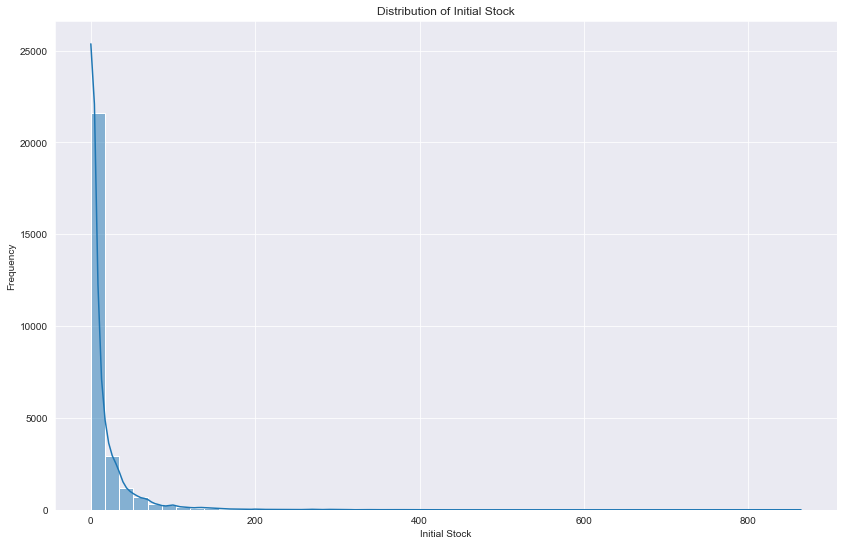

In [143]:
# Plotting the distribution of 'stock_initial'
plt.figure(figsize=(14, 9))
sns.histplot(df_clean_train['average_monthly_consumption'], kde=True, bins=50)
plt.title('Distribution of Initial Stock')
plt.xlabel('Initial Stock')
plt.ylabel('Frequency')
plt.show()

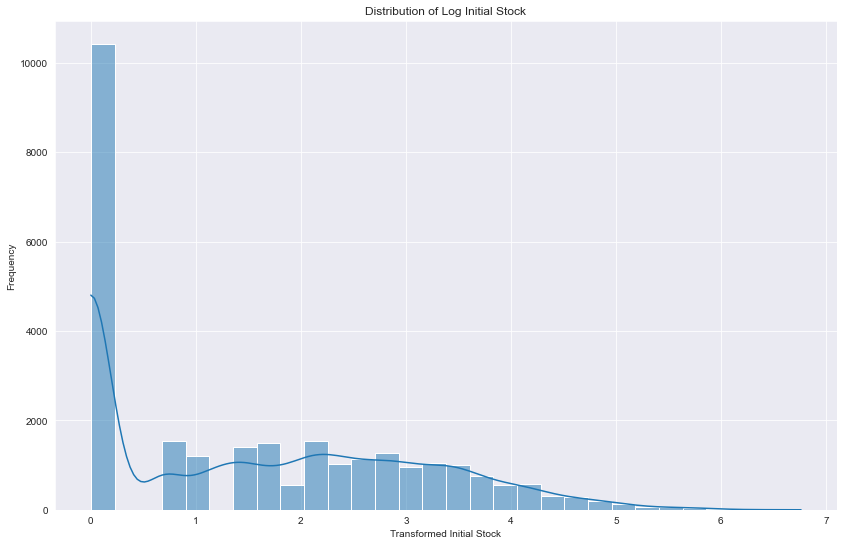

In [144]:
# Plotting the distribution of 'log stock_initial'
plt.figure(figsize=(14, 9))
sns.histplot(np.log1p(df_clean_train['average_monthly_consumption']), kde=True, bins=30)
plt.title('Distribution of Log Initial Stock')
plt.xlabel('Transformed Initial Stock')
plt.ylabel('Frequency')
plt.show()

In [145]:
def replace_extremes(dataset, column, method='IQR', extreme_value='median', multiplier=1.5):
    """
    Replace extreme values in a numerical column based on the IQR method and print the percentage of extreme values.
    
    Parameters:
    data (DataFrame): The DataFrame containing the numerical column.
    column (str): The name of the numerical column to process.
    method (str): Method to calculate the extreme value limit ('IQR' or 'STD', default is 'IQR').
    extreme_value (str): The value to replace extremes with ('median', 'mean', or a specific number, default is 'median').
    multiplier (float): The multiplier for IQR or STD to define extremes (default is 1.5).
    
    Returns:
    DataFrame: The DataFrame with extreme values replaced.
    """
    data = dataset.copy()
    if method == 'IQR':
        # Calculate Q1, Q3, and IQR
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        # Define extreme value limits
        lower_limit = Q1 - multiplier * IQR
        upper_limit = Q3 + multiplier * IQR
    elif method == 'STD':
        # Calculate mean and standard deviation
        mean = data[column].mean()
        std = data[column].std()
        # Define extreme value limits
        lower_limit = mean - multiplier * std
        upper_limit = mean + multiplier * std
    else:
        raise ValueError("Invalid method. Choose 'IQR' or 'STD'.")

    # Calculate extreme value counts
    lower_extremes_count = (data[column] < lower_limit).sum()
    upper_extremes_count = (data[column] > upper_limit).sum()
    total_extremes_count = lower_extremes_count + upper_extremes_count

    # Calculate and print the percentage of extreme values
    total_values_count = data.shape[0]
    percentage_extremes = (total_extremes_count / total_values_count) * 100
    print(f"Percentage of extreme values: {percentage_extremes:.2f}%")

    # Define replacement value
    if extreme_value == 'median':
        replacement = data[column].median()
    elif extreme_value == 'mean':
        replacement = mean
    else:
        replacement = extreme_value

    # Replace the extreme values
    data[column] = data[column].mask(data[column] < lower_limit, replacement)
    data[column] = data[column].mask(data[column] > upper_limit, replacement)

    return data


stock_initial
Percentage of extreme values: 6.36%
stock_received
Percentage of extreme values: 16.92%
stock_distributed
Percentage of extreme values: 11.05%
stock_adjustment
Percentage of extreme values: 5.02%
stock_end
Percentage of extreme values: 6.22%
average_monthly_consumption
Percentage of extreme values: 8.17%
stock_ordered
Percentage of extreme values: 11.91%
stock_to_demand_ratio
Percentage of extreme values: 13.94%
rolling_avg_3m_stock_dist
Percentage of extreme values: 8.42%
rolling_avg_6m_stock_dist
Percentage of extreme values: 7.77%
high_demand_season
Percentage of extreme values: 0.00%
low_demand_season
Percentage of extreme values: 24.55%
rate_change_stock_dist
Percentage of extreme values: 33.13%
cumulative_stock_received
Percentage of extreme values: 9.44%
cumulative_stock_distributed


C:\Users\andil\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


Percentage of extreme values: 8.70%
std_dev_6m_stock_dist
Percentage of extreme values: 8.19%
lag_1_stock_dist
Percentage of extreme values: 11.34%
lag_2_stock_dist
Percentage of extreme values: 11.65%


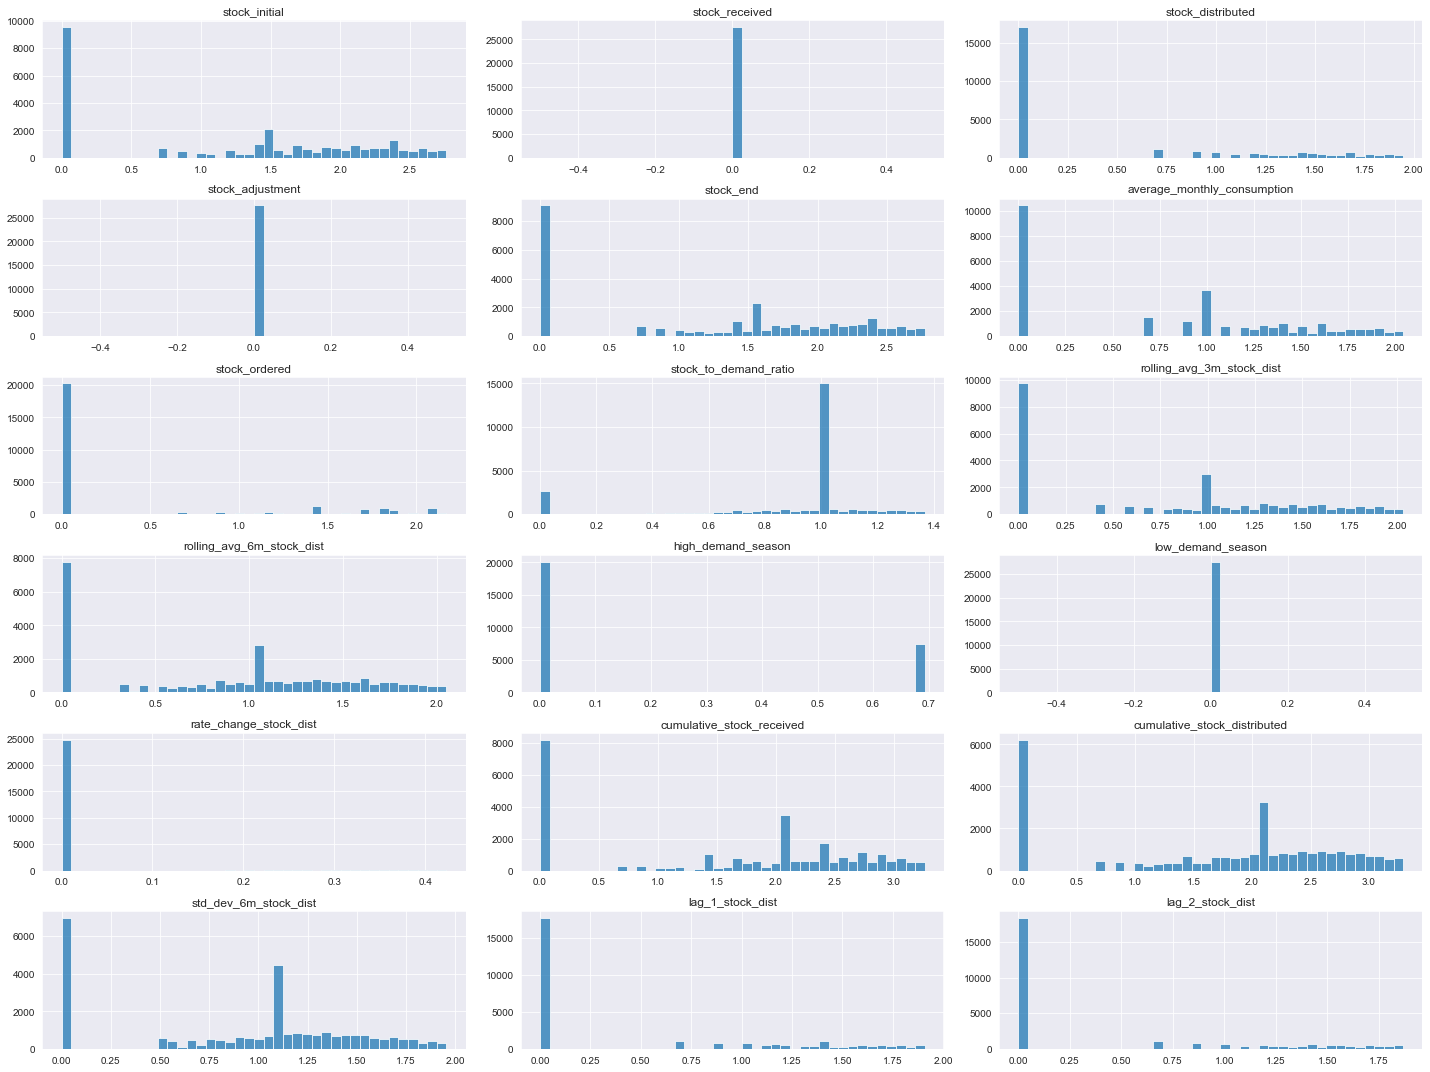

In [181]:
# List of variables for univariate analysis
variables = ['stock_initial', 'stock_received', 'stock_distributed', 'stock_adjustment', 'stock_end',
             'average_monthly_consumption', 'stock_ordered', 'stock_to_demand_ratio', 'rolling_avg_3m_stock_dist',
             'rolling_avg_6m_stock_dist', 'high_demand_season', 'low_demand_season',
             'rate_change_stock_dist', 'cumulative_stock_received', 'cumulative_stock_distributed',
             'std_dev_6m_stock_dist', 'lag_1_stock_dist', 'lag_2_stock_dist']

# Setting up the matplotlib figure
plt.figure(figsize=(20, 15))

# Plotting each variable
for i, var in enumerate(variables):
    print(var)
    plt.subplot(6, 3, i+1)
    dft_trans = replace_extremes(df_clean_train, var, method='IQR', multiplier=2)
    trans = np.log1p(np.sqrt(dft_trans[var]))
    sns.histplot(trans, kde=False, bins=40)
    plt.title(var)
    plt.xlabel('')
    plt.ylabel('')

plt.tight_layout()
plt.show()


In [147]:

# Function to calculate trendline_stock_distributed
def calculate_trendline(data, poly_degree=3):

    X = data['date'].values.reshape(-1,1)
    y = data['stock_distributed'].values.reshape(-1,1)

    polynomial_features= PolynomialFeatures(degree=poly_degree)
    x_poly = polynomial_features.fit_transform(X)

    model = LinearRegression()
    model.fit(x_poly, y)

    data['trendline_stock_distributed'] = model.predict(x_poly)
    return data

# Apply the function to the train and test sets separately
df_clean_train = calculate_trendline(df_clean_train)
df_clean_test = calculate_trendline(df_clean_test)


In [148]:
df_clean_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27613 entries, 31887 to 8921
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   year                          27613 non-null  int64  
 1   month                         27613 non-null  int64  
 2   region                        27613 non-null  object 
 3   district                      27613 non-null  object 
 4   site_code                     27613 non-null  object 
 5   product_code                  27613 non-null  object 
 6   stock_initial                 27613 non-null  int64  
 7   stock_received                27613 non-null  int64  
 8   stock_distributed             27613 non-null  int64  
 9   stock_adjustment              27613 non-null  int64  
 10  stock_end                     27613 non-null  int64  
 11  average_monthly_consumption   27613 non-null  int64  
 12  stock_ordered                 27613 non-null  float64
 13

In [149]:
# FE: stockout var
def check_stockout(row):
    if (row['stock_initial'] > 0 or row['stock_received'] > 0) and row['stock_end'] == 0:
        return 1
    else:
        return 0

df_clean_train['stockout'] = df_clean_train.apply(check_stockout, axis=1)
df_clean_test['stockout'] = df_clean_test.apply(check_stockout, axis=1)

# FE:  Stock utilization rate
df_clean_train['stock_utilization'] = (df_clean_train.average_monthly_consumption /
                                      (df_clean_train['stock_initial'] + df_clean_train['stock_received']))
df_clean_test['stock_utilization'] = (df_clean_test.average_monthly_consumption / 
                                      (df_clean_test['stock_initial'] + df_clean_test['stock_received']))


In [150]:
df_clean_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27613 entries, 31887 to 8921
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   year                          27613 non-null  int64  
 1   month                         27613 non-null  int64  
 2   region                        27613 non-null  object 
 3   district                      27613 non-null  object 
 4   site_code                     27613 non-null  object 
 5   product_code                  27613 non-null  object 
 6   stock_initial                 27613 non-null  int64  
 7   stock_received                27613 non-null  int64  
 8   stock_distributed             27613 non-null  int64  
 9   stock_adjustment              27613 non-null  int64  
 10  stock_end                     27613 non-null  int64  
 11  average_monthly_consumption   27613 non-null  int64  
 12  stock_ordered                 27613 non-null  float64
 13

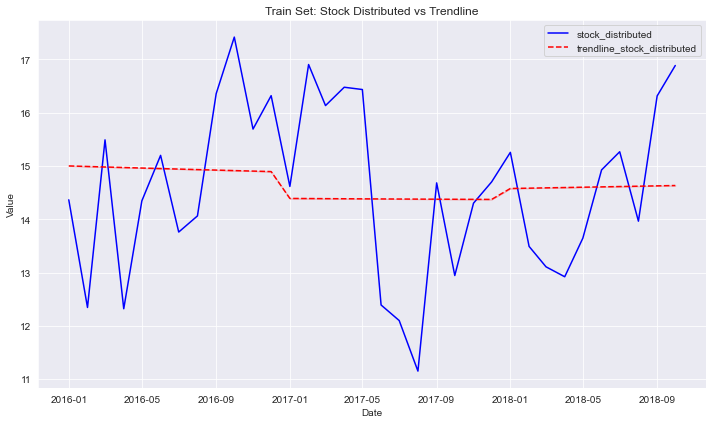

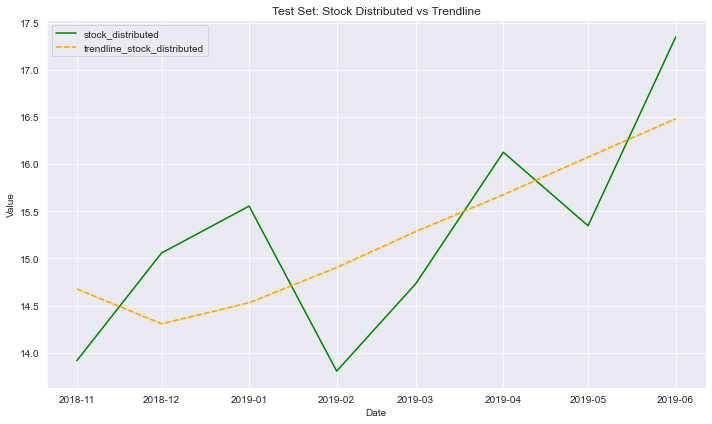

In [151]:

# Convert the date column to datetime format
df_clean_train['date'] = pd.to_datetime(df_clean_train['date'], format='%Y%m')
df_clean_test['date'] = pd.to_datetime(df_clean_test['date'], format='%Y%m')

# Plot for the train set
plt.figure(figsize=(10, 6))
sns.lineplot(x='date', y='stock_distributed', data=df_clean_train, color='blue', label='stock_distributed', ci=None)
sns.lineplot(x='date', y='trendline_stock_distributed', data=df_clean_train, color='red', linestyle='--', label='trendline_stock_distributed')
plt.title('Train Set: Stock Distributed vs Trendline')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot for the test set
plt.figure(figsize=(10, 6))
sns.lineplot(x='date', y='stock_distributed', data=df_clean_test, color='green', label='stock_distributed', ci=None)
sns.lineplot(x='date', y='trendline_stock_distributed', data=df_clean_test, color='orange', linestyle='--', label='trendline_stock_distributed')
plt.title('Test Set: Stock Distributed vs Trendline')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [152]:
df_clean_train = df_clean_train.sort_values(by=['site_code', 'product_code', 'date'])
# Calculate growth rate
df_clean_train['consumption_growth_rate'] = df_clean_train.groupby(['site_code', 'product_code'])['stock_distributed'].pct_change() * 100
# Replace inf with NaN (or another value)
df_clean_train['consumption_growth_rate'].replace([np.inf, -np.inf], np.nan, inplace=True)
# Fill NaN values using forward fill within each group
df_clean_train['consumption_growth_rate'] = df_clean_train.groupby(['site_code', 'product_code'])['consumption_growth_rate'].fillna(method='ffill').fillna(method='bfill')

In [153]:
df_clean_test = df_clean_test.sort_values(by=['site_code', 'product_code', 'date'])
# Calculate growth rate
df_clean_test['consumption_growth_rate'] = df_clean_test.groupby(['site_code', 'product_code'])['stock_distributed'].pct_change() * 100
# Replace inf with NaN (or another value)
df_clean_test['consumption_growth_rate'].replace([np.inf, -np.inf], np.nan, inplace=True)
# Fill NaN values using forward fill within each group
df_clean_test['consumption_growth_rate'] = df_clean_test.groupby(['site_code', 'product_code'])['consumption_growth_rate'].fillna(method='ffill').fillna(method='bfill')

C:\Users\andil\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\andil\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\andil\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\andil\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 1.0, 'Distribution of Transformed Consumption Growth Rate on Test set')

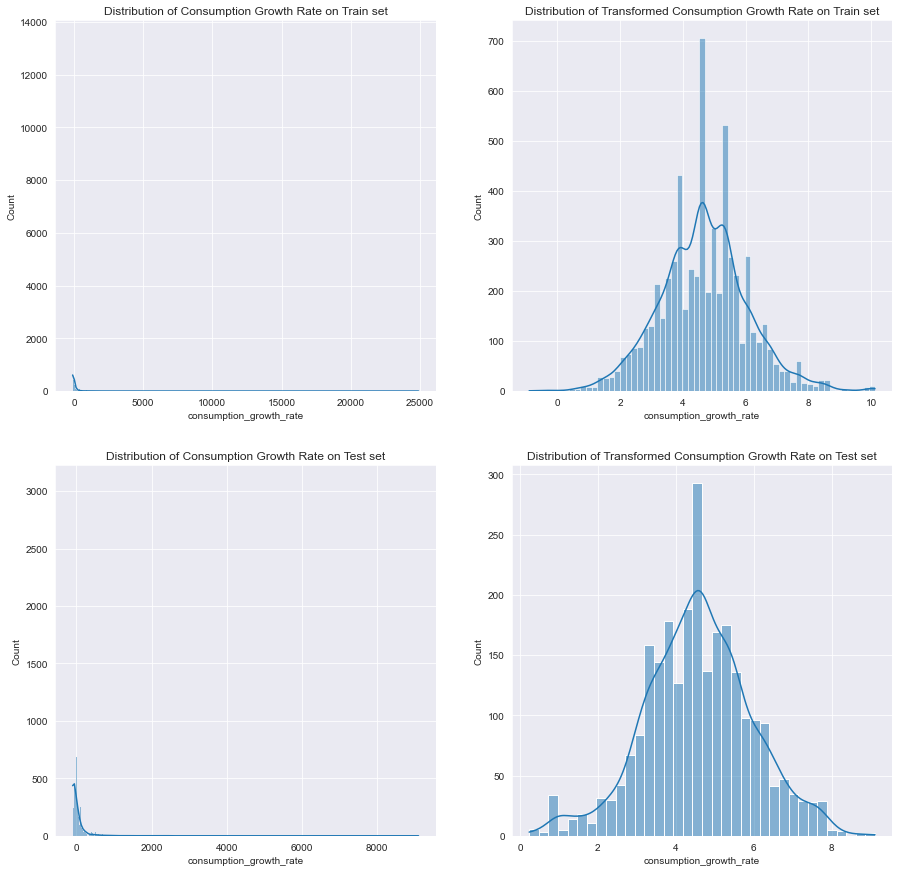

In [154]:
# Set up the figure and axes
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))

sns.histplot(df_clean_train['consumption_growth_rate'], kde=True, ax=axs[0, 0])
axs[0, 0].set_title('Distribution of Consumption Growth Rate on Train set', fontsize=20)
sns.histplot(np.log(df_clean_train['consumption_growth_rate']), kde=True, ax=axs[0, 1])
axs[0, 1].set_title('Distribution of Transformed Consumption Growth Rate on Train set')

sns.histplot(df_clean_test['consumption_growth_rate'], kde=True, ax=axs[1, 0])
axs[1, 0].set_title('Distribution of Consumption Growth Rate on Test set')
sns.histplot(np.log(df_clean_test['consumption_growth_rate']), kde=True, ax=axs[1, 1])
axs[1, 1].set_title('Distribution of Transformed Consumption Growth Rate on Test set')

C:\Users\andil\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\andil\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


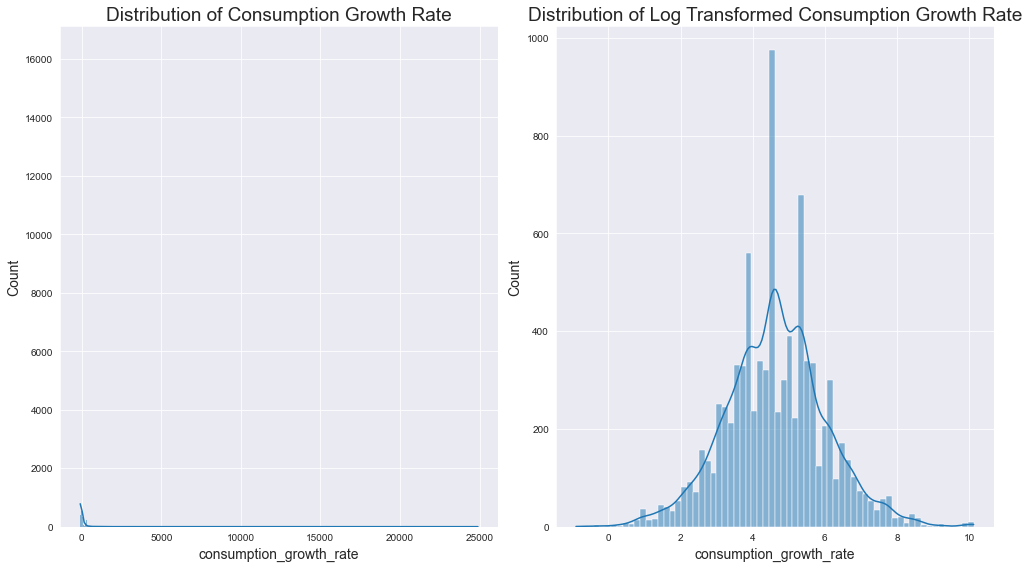

In [196]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 8))
comb = pd.concat([df_clean_train, df_clean_test])
sns.histplot(comb['consumption_growth_rate'], kde=True, ax=axs[0])
axs[0].set_title('Distribution of Consumption Growth Rate', fontsize=19)
sns.histplot(np.log(comb['consumption_growth_rate']), kde=True, ax=axs[1])
axs[1].set_title('Distribution of Log Transformed Consumption Growth Rate', fontsize=19)
for ax in axs.flat:
    ax.set_xlabel(ax.get_xlabel(), fontsize=14)
    ax.set_ylabel(ax.get_ylabel(), fontsize=14)
plt.tight_layout()
plt.show()

In [156]:
def replace_extremes_and_impute(df):
    """
    Function to find infinity or extremely large values in numerical columns, replace them with NaNs,
    and then replace NaNs with the median for numerical columns and mode for categorical columns.
    """
    # For each column in the DataFrame
    for col in df.columns:
        if df[col].dtype in ['int64', 'float64']:  # If the column is numerical
            # Replace inf/-inf with NaN
            df[col].replace([np.inf, -np.inf], np.nan, inplace=True)

            # Find and replace extremely large values with NaN
            extreme_value_threshold = 1e8
            df[col] = df[col].mask(df[col].abs() > extreme_value_threshold, np.nan)

            # Impute missing values with median
            median = df[col].median()
            df[col].fillna(median, inplace=True)
        elif df[col].dtype == 'object':  # If the column is categorical
            # Impute missing values with mode (most frequent value)
            if not df[col].isna().all():  # Check if the column has non-NaN values
                mode = df[col].mode()[0]
                df[col].fillna(mode, inplace=True)
            else:
                df[col].fillna('Unknown', inplace=True)  # Fallback value for all NaN columns

    return df


In [157]:
df_clean_train = replace_extremes_and_impute(df_clean_train)
df_clean_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27613 entries, 28705 to 23938
Data columns (total 36 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   year                          27613 non-null  int64         
 1   month                         27613 non-null  int64         
 2   region                        27613 non-null  object        
 3   district                      27613 non-null  object        
 4   site_code                     27613 non-null  object        
 5   product_code                  27613 non-null  object        
 6   stock_initial                 27613 non-null  int64         
 7   stock_received                27613 non-null  int64         
 8   stock_distributed             27613 non-null  int64         
 9   stock_adjustment              27613 non-null  int64         
 10  stock_end                     27613 non-null  int64         
 11  average_monthly_consumpt

In [158]:
df_clean_test = replace_extremes_and_impute(df_clean_test)
df_clean_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8140 entries, 816 to 3885
Data columns (total 36 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   year                          8140 non-null   int64         
 1   month                         8140 non-null   int64         
 2   region                        8140 non-null   object        
 3   district                      8140 non-null   object        
 4   site_code                     8140 non-null   object        
 5   product_code                  8140 non-null   object        
 6   stock_initial                 8140 non-null   int64         
 7   stock_received                8140 non-null   int64         
 8   stock_distributed             8140 non-null   int64         
 9   stock_adjustment              8140 non-null   int64         
 10  stock_end                     8140 non-null   int64         
 11  average_monthly_consumption 

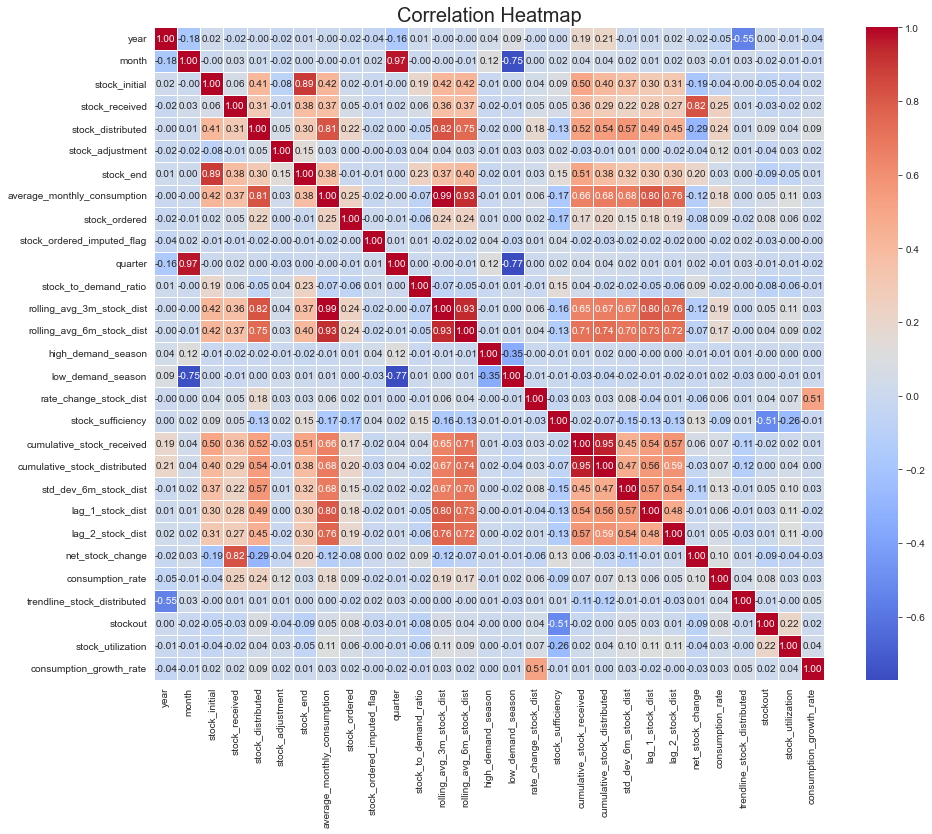

In [201]:
plt.figure(figsize=(15, 12))
sns.heatmap(df_clean_train.corr(), cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap", fontsize=20)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

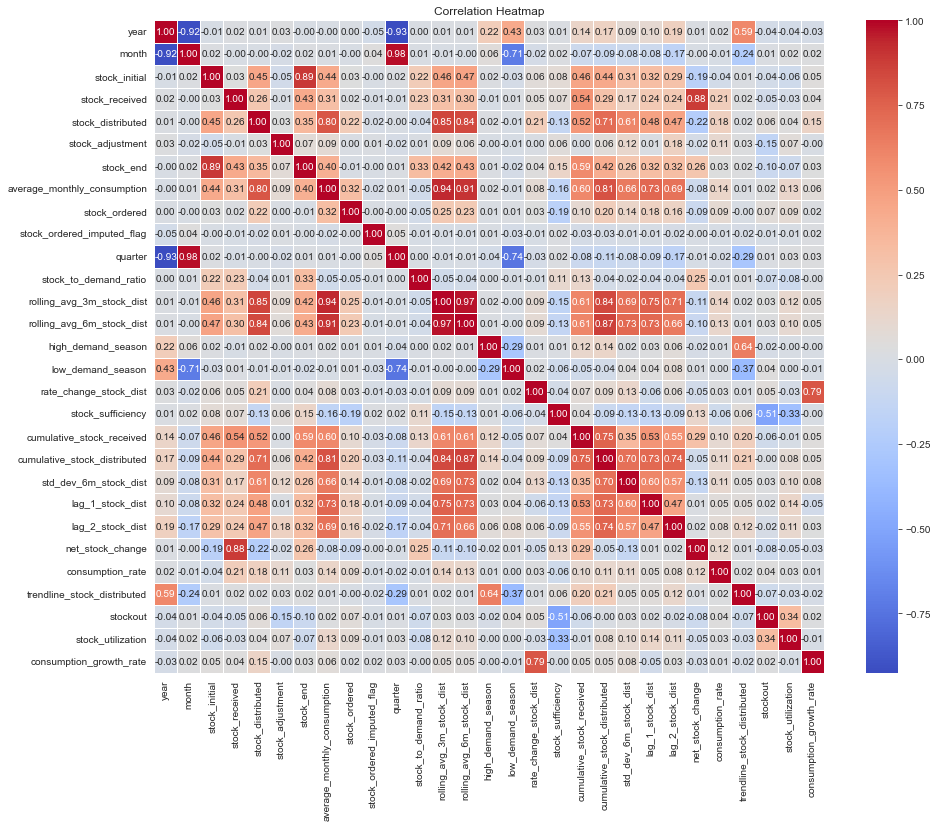

In [160]:
plt.figure(figsize=(15, 12))
sns.heatmap(df_clean_test.corr(), cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

In [161]:
print(df_clean_train.shape)
print(df_clean_test.shape)

(27613, 36)
(8140, 36)


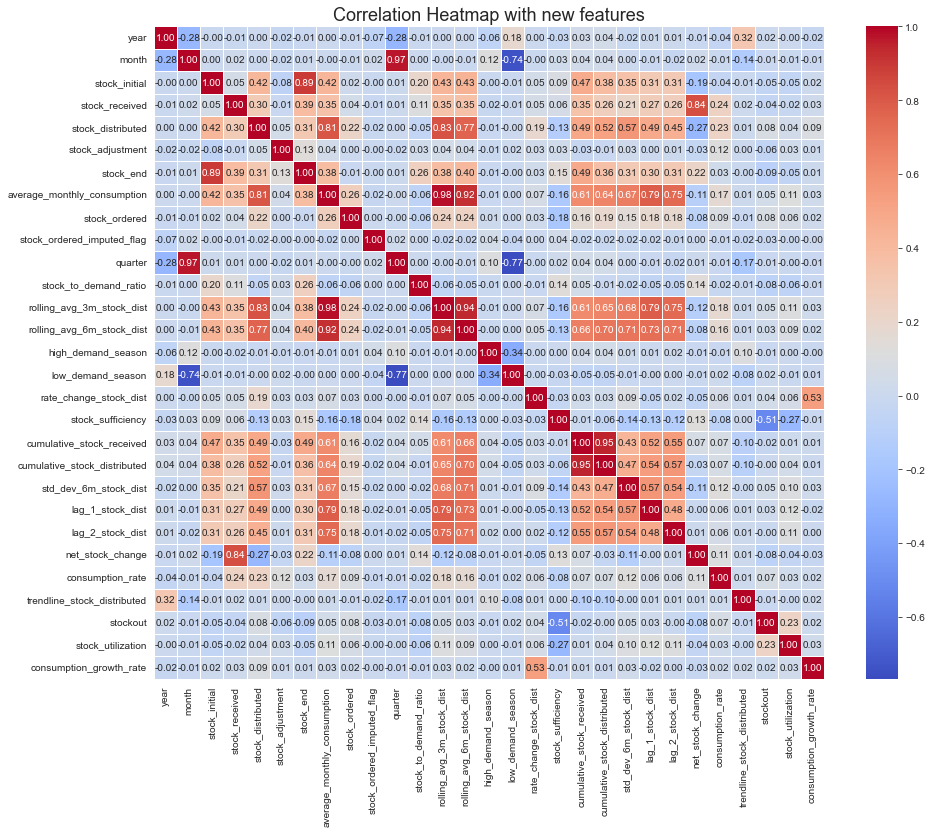

In [203]:
df_combined = pd.concat([df_clean_train, df_clean_test])

plt.figure(figsize=(15, 12))
sns.heatmap(df_combined.corr(), cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap with new features", fontsize=18)
plt.show()

In [178]:

grouped_data = df_combined.groupby('region')['stock_distributed']

# Conducting Kruskal-Wallis Test
kruskal_result = kruskal(*[group.values for name, group in grouped_data])
print('Kruskal-Wallis result:', kruskal_result)

Kruskal-Wallis result: KruskalResult(statistic=670.3764278563309, pvalue=6.7463749537781095e-130)


In [164]:
df_clean_train.to_parquet('../Data/Processed/df_clean_train.parquet', engine='pyarrow')
df_clean_test.to_parquet('../Data/Processed/df_clean_test.parquet', engine='pyarrow')  


In [175]:
grouped_data.mean()

site_code
C1004    16.290323
C1007    20.334416
C1008     9.754647
C1009    14.834951
C1010    11.299180
           ...    
C5020     5.895161
C5021     6.467337
C5060    19.329843
C5063     1.981627
C5066     2.752066
Name: stock_distributed, Length: 155, dtype: float64

In [170]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29 entries, year to consumption_growth_rate
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   year                          29 non-null     float64
 1   month                         29 non-null     float64
 2   stock_initial                 29 non-null     float64
 3   stock_received                29 non-null     float64
 4   stock_distributed             29 non-null     float64
 5   stock_adjustment              29 non-null     float64
 6   stock_end                     29 non-null     float64
 7   average_monthly_consumption   29 non-null     float64
 8   stock_ordered                 29 non-null     float64
 9   stock_ordered_imputed_flag    29 non-null     float64
 10  quarter                       29 non-null     float64
 11  stock_to_demand_ratio         29 non-null     float64
 12  rolling_avg_3m_stock_dist     29 non-null     f

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''